In [230]:
import stan
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# work around to get stan working in a notebook
import nest_asyncio
nest_asyncio.apply()
del nest_asyncio

In [216]:
# df = pd.read_csv('final_voting_data_long.csv')
df = pd.read_csv('df_main.csv')
# df['has_border'] = df['has_border'].replace(np.nan,0)
print(df.columns)
df.head()

Index(['year', 'Artist', 'from_country', 'to_country', 'points',
       'total_points', 'rank', 'from_code2', 'from_code3', 'to_code2',
       'to_code3', 'Official_languages', 'Language_sung', 'Contains_English',
       'Contains_NonEnglish', 'Contains_Multiple_Languages',
       'Number_of_Languages', 'Contains_Own_Language', 'gender',
       'migration_v2p', 'population_p', 'prop_emigrants_v2p', 'migration_p2v',
       'population_v', 'prop_emigrants_p2v', 'migration_pop_year',
       'comps_since_last_win'],
      dtype='object')


,year,Artist,from_country,to_country,points,total_points,rank,from_code2,from_code3,to_code2,...,Contains_Own_Language,gender,migration_v2p,population_p,prop_emigrants_v2p,migration_p2v,population_v,prop_emigrants_p2v,migration_pop_year,comps_since_last_win
0,1998,Danijela,belgium,croatia,5,131,5.0,BE,BEL,HR,...,True,female,205.0,4620030.0,0.000044,72.0,10136811.0,0.000007,1995.0,42
1,1998,Michael Hajiyanni,belgium,cyprus,2,37,11.0,BE,BEL,CY,...,True,male,92.0,862418.0,0.000107,77.0,10136811.0,0.000008,1995.0,42
2,1998,Koit Toome,belgium,estonia,0,36,12.0,BE,BEL,EE,...,True,male,0.0,1436634.0,0.000000,57.0,10136811.0,0.000006,1995.0,42
3,1998,Vlado Janevski,belgium,north macedonia,0,16,19.0,BE,BEL,MK,...,True,male,NaN,NaN,NaN,120.0,10136811.0,0.000012,1995.0,42
4,1998,Edea,belgium,finland,0,22,15.0,BE,BEL,FI,...,True,group,144.0,5107790.0,0.000028,1541.0,10136811.0,0.000152,1995.0,42


In [217]:
def format_votes(x):
  if x == 12.:
    return 10
  elif x == 10.:
    return 9
  return int(x)
df['indexed_votes'] = df['points'].apply(format_votes) + 1
score_options = df['indexed_votes'].unique().tolist()
score_options.sort()
print(score_options)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [218]:
# Given gender is a categoric variable with 3 classes, encode as binary w.r.t default gender='group'
df['male'] = [1 if gender=='male' else 0 for gender in df['gender']]
df['female'] = [1 if gender=='female' else 0 for gender in df['gender']]

# Evaluate binary variables for boolean covariates to be used
df['Contains_English_bin'] = df['Contains_English'].apply(lambda x: 1 if x else 0)
df['Contains_Own_Language_bin'] = df['Contains_Own_Language'].apply(lambda x: 1 if x else 0)

In [219]:
# build vector of voter/performer pair indicies and corresponding lookup tables
performers = sorted(df['to_code2'].unique())
voters = sorted(df['from_code2'].unique())
print(f"number of voters: {len(voters)}")
print(f"number of performers: {len(performers)}")
diff =  set(voters) - set(performers)
print(f'\nThose who have voted but not performed: {diff}')

# # create 0-indexed lookup tables for voter-performer pairings
vptoi = {}
itovp = {}
counter = 0
for p in performers:
    for v in voters:
        # only include v-p pairs that have occured in the data, different countries were voting and performing in different years
        if ( p != v ) and ( not df.loc[ (df['from_code2'] == v) & (df['to_code2'] == p) ].empty ):
            vptoi[f'{v}-{p}'] = counter
            itovp[f'{counter}'] = f'{v}-{p}'
            counter += 1

df['vp'] = df.apply(lambda x: vptoi[f'{x["from_code2"]}-{x["to_code2"]}'], axis=1)
print(f"\ncheck index of BE-HR: {vptoi['BE-HR']}")
print(f"check index of BE-CY: {vptoi['BE-CY']}")
df[ ["from_code2","to_code2","vp"]].head()

number of voters: 49
number of performers: 47

Those who have voted but not performed: {'MC', 'AD'}

check index of BE-HR: 993
check index of BE-CY: 474


,from_code2,to_code2,vp
0,BE,HR,993
1,BE,CY,474
2,BE,EE,661
3,BE,MK,1461
4,BE,FI,755


In [220]:
# test/train split
# Reserve data from 2022 for testing model on unseen data
print(f'full df shape: {df.shape}')
df_train = df.loc[ df['year'] <= 2018 ]
df_test = df.loc[ df['year'] > 2018 ]
print(f'train df shape: {df_train.shape}')
print(f'test df shape: {df_test.shape}')

full df shape: (21310, 33)
train df shape: (18307, 33)
test df shape: (3003, 33)


In [221]:
model = """
data {
  int<lower=2> S;
  int<lower=0> N;   // total number of performances
  int<lower=1> B;   // number of performance dependent covariates
  int<lower=1> PHI; // number of voter/performer pair dependent covariates
  int<lower=1> VP;  // number of voter/performer combinations

  array[N] int<lower=1, upper=S> y;
  array[N] row_vector[B] xbeta;       // performance dependent covariates
  array[VP] row_vector[PHI] xphi;     // voter/performer pair dependent covariates
  array[N] int<lower=0,upper=VP-1> vp;  // voter/performer pair index

  //int<lower=0> N_new; // number of predictions
  //array[N_new] row_vector[D] x_new; // covariates for predictions
}
parameters {
  vector[B] beta;
  vector[PHI] phi;
  vector[VP] alpha;
  ordered[S-1] lambda;
  real gamma;
  real<lower=0> sigmaAlpha;
}
model {
  gamma ~ normal(0, 10000);
  beta ~ normal(0, 10000);
  lambda ~ normal(0, 3.2);
  sigmaAlpha ~ cauchy(0,1);

  for (i in 1:VP) {
    alpha[i] ~ normal( xphi[i] * phi, sigmaAlpha );
  }
  
  for (n in 1:N) {
    // remembering that vp is 0-indexed and alpha is 1-indexed
    y[n] ~ ordered_logistic( gamma + alpha[ vp[n] + 1 ] + (xbeta[n] * beta), lambda );
  }
}
generated quantities {
  vector[N] y_hat;
  for (n in 1:N) {
    y_hat[n] = ordered_logistic_rng( gamma + alpha[ vp[n] ] + (xbeta[n] * beta), lambda);
  }

  // out of sample predictions (scores we expet to observe for new data)
  //vector[N_new] y_pred;
  //for (n in 1:N_new)
  //    y_pred[n] = ordered_logistic_rng(x_new[n] * beta, lambda);
}
"""

In [222]:
# build xbeta matrix
xbeta_train = df_train.loc[:,['Contains_English_bin','Contains_Own_Language_bin','male','female','comps_without_win']].values
print(xbeta_train.shape)
# minmax scaling of 'comps_since_last_win'
scaler = MinMaxScaler() 
xbeta_train_norm = scaler.fit_transform(xbeta_train)

(18307, 5)


The xphi matrix has shape (num of v-p pairs, 2)
The two colums contain a binary measure of whether or not the voter shares a border with the performer, and a measure of the intensity of the migration from the voter to the performer. The latter is calculated as an average over time:

ave intensity = mean( num migrants from v to p / population of v )

In [223]:
df_border = pd.read_csv('final_border_data_long.csv')
df_border.head()

,Unnamed: 0,country_code_1,country_code_2,has_border
0,0,AT,AT,NaN
1,1,AT,BA,NaN
2,2,AT,BE,NaN
3,3,AT,CY,NaN
4,4,AT,DE,1.0


mean = 0.0 count: 13
mean = nan count: 473

Note that 21.75% of the v-p pairs get the substitute value for migration intensity because there was no migration information.


Text(0.5, 1.0, 'distribution of available non-zero migration data (used to infer missing data)')

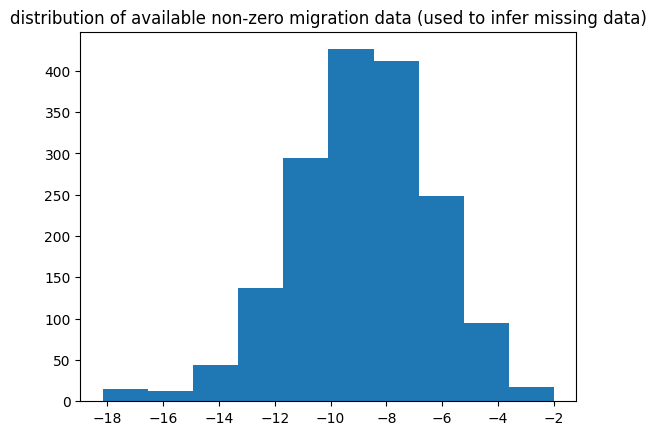

In [224]:
# build xphi matrix
xphi = np.zeros((len(vptoi), 2))
migration_means = []
zero_count = 0
nan_count = 0
for pair,idx in vptoi.items():
    v = pair[:2]
    p = pair[-2:]
    has_border = df_border.loc[ (df_border['country_code_1'] == v) & (df_border['country_code_2'] == p) ]['has_border'].item()
    xphi[idx][0] = 0.0 if math.isnan(has_border) else has_border

    migration_series = df.loc[ (df['from_code2'] == v) & (df['to_code2'] == p) ]['prop_emigrants_v2p']
    if migration_series.isnull().any():
        # if no migration data is available, use the plot below to infer the most appropriate substitute value
        # this should be a better alternative to assuming 0 migration
        xphi[idx][1] = math.exp(-9) - 2.6e-08/2
        nan_count += 1
    else:
        mean_migration = migration_series.mean()
        xphi[idx][1] = mean_migration

        # below lines for informational purpose
        if mean_migration == 0.0:
            zero_count +=1
        migration_means.append(mean_migration)

print(f'mean = 0.0 count: {zero_count}')
print(f'mean = nan count: {nan_count}')
print(f'\nNote that {round(100*nan_count/len(vptoi),2)}% of the v-p pairs get the substitute value for migration intensity because there was no migration information.')
plt.hist(np.log(np.array(migration_means) + 2.6e-08/2)) # translate by half of smallest non-zero value
plt.title('distribution of available non-zero migration data (used to infer missing data)')

    

smallest non-zero value: 2.6071052952733155e-08


Text(0.5, 1.0, 'normalised migration intensity values for 2175 v-p pairs')

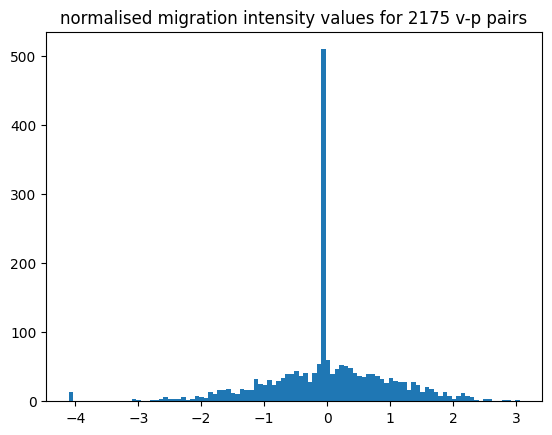

In [225]:
# standardise the migration intensity feature in xphi with a log transform and standardisation
mig_ints = xphi[:,1]
mig_ints_sort = np.sort(mig_ints)
print(f'smallest non-zero value: {mig_ints_sort[mig_ints_sort != 0][0]}')

mig_ints_log = np.log10(mig_ints + 2.6e-08/2)   # rule of thumb, half of smallest non-zero value
std_scaler = StandardScaler()
mig_ints_log_std = std_scaler.fit_transform(mig_ints_log.reshape(-1, 1))

# write scaler version of xphi
xphi_norm = xphi.copy()
xphi_norm[:,1] = mig_ints_log_std.reshape((2175,))

plt.hist(xphi_norm[:,1],bins=100)
plt.title(f'normalised migration intensity values for {len(vptoi)} v-p pairs')


In [226]:
data = {
    'S': 11,
    'N': df_train.shape[0],
    'B': xbeta_train_norm.shape[1],
    'PHI' : xphi_norm.shape[1],
    'VP' : xphi_norm.shape[0],
    'y': df_train['indexed_votes'].values,
    'xbeta': xbeta_train_norm,
    'xphi' : xphi_norm,
    'vp' : df_train['vp'].values
    # 'N_new': df.shape[0]-n_train,
    # 'x_new': x_test
}

In [228]:
posterior = stan.build(model, data=data)
fit = posterior.sample(num_chains=4, num_warmup=1000, num_samples=5000)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/82/6xch38_95_d545t14cp867pc0000gr/T/httpstan_esna5w_3/model_snhj3are.stan', line 27, column 19: Argument
    10000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/82/6xch38_95_d545t14cp867pc0000gr/T/httpstan_esna5w_3/model_snhj3are.stan', line 26, column 20: Argument
    10000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/24000)
Sampling:   0% (2/24000)
Sampling:   0% (3/24000)
Sampling:   0% (102/24000)
Sampling:   1% (201/24000)
Sampling:   1% (300/24000)Future exception was neve

ClientPayloadError: Response payload is not completed

In [232]:
az_fit = az.from_pystan(
    posterior=fit, 
    observed_data="y", 
    posterior_predictive="y_hat",
    # predictions="y_pred", 
    posterior_model=posterior)

ModuleNotFoundError: No module named 'pystan'

array([[<Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n0'}>],
       [<Axes: title={'center': 'beta\n1'}>,
        <Axes: title={'center': 'beta\n1'}>],
       [<Axes: title={'center': 'beta\n2'}>,
        <Axes: title={'center': 'beta\n2'}>],
       [<Axes: title={'center': 'beta\n3'}>,
        <Axes: title={'center': 'beta\n3'}>],
       [<Axes: title={'center': 'beta\n4'}>,
        <Axes: title={'center': 'beta\n4'}>]], dtype=object)

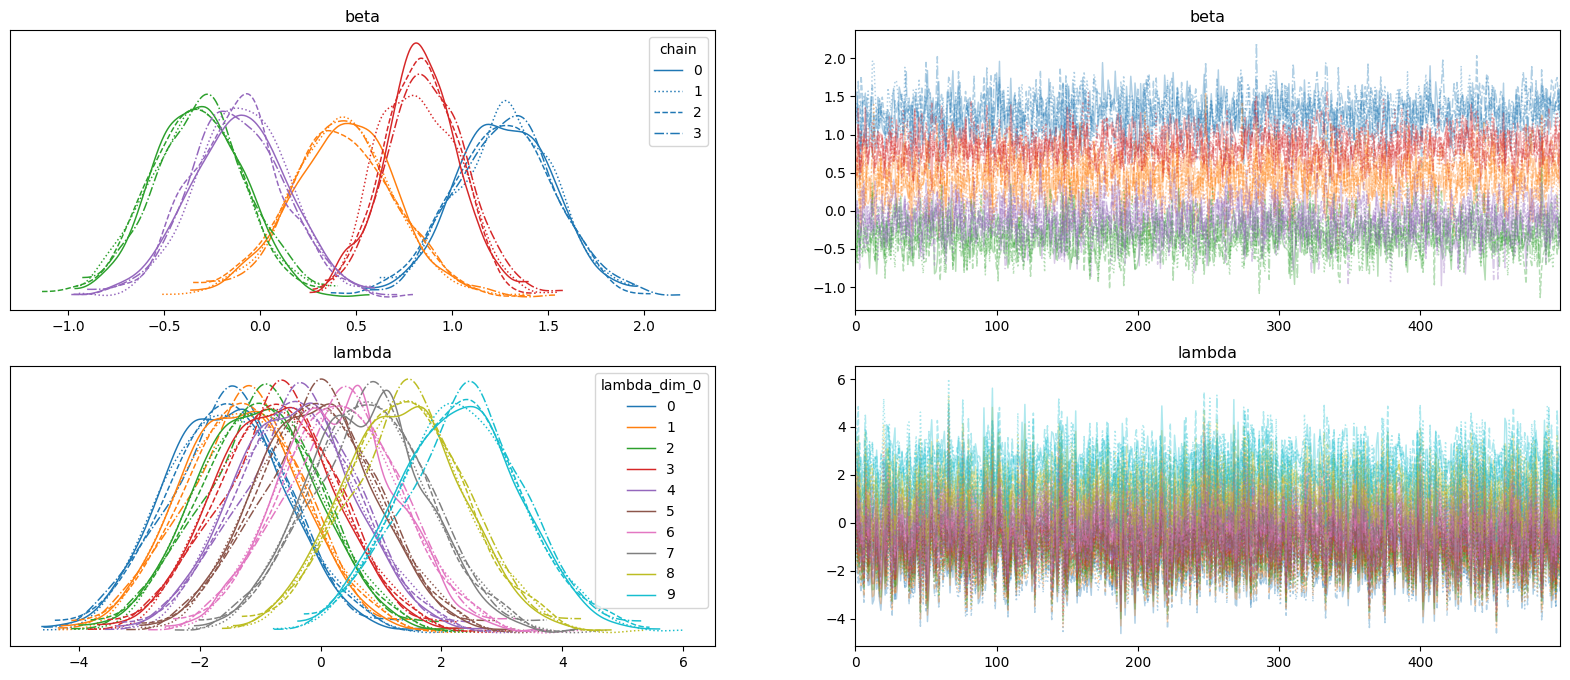

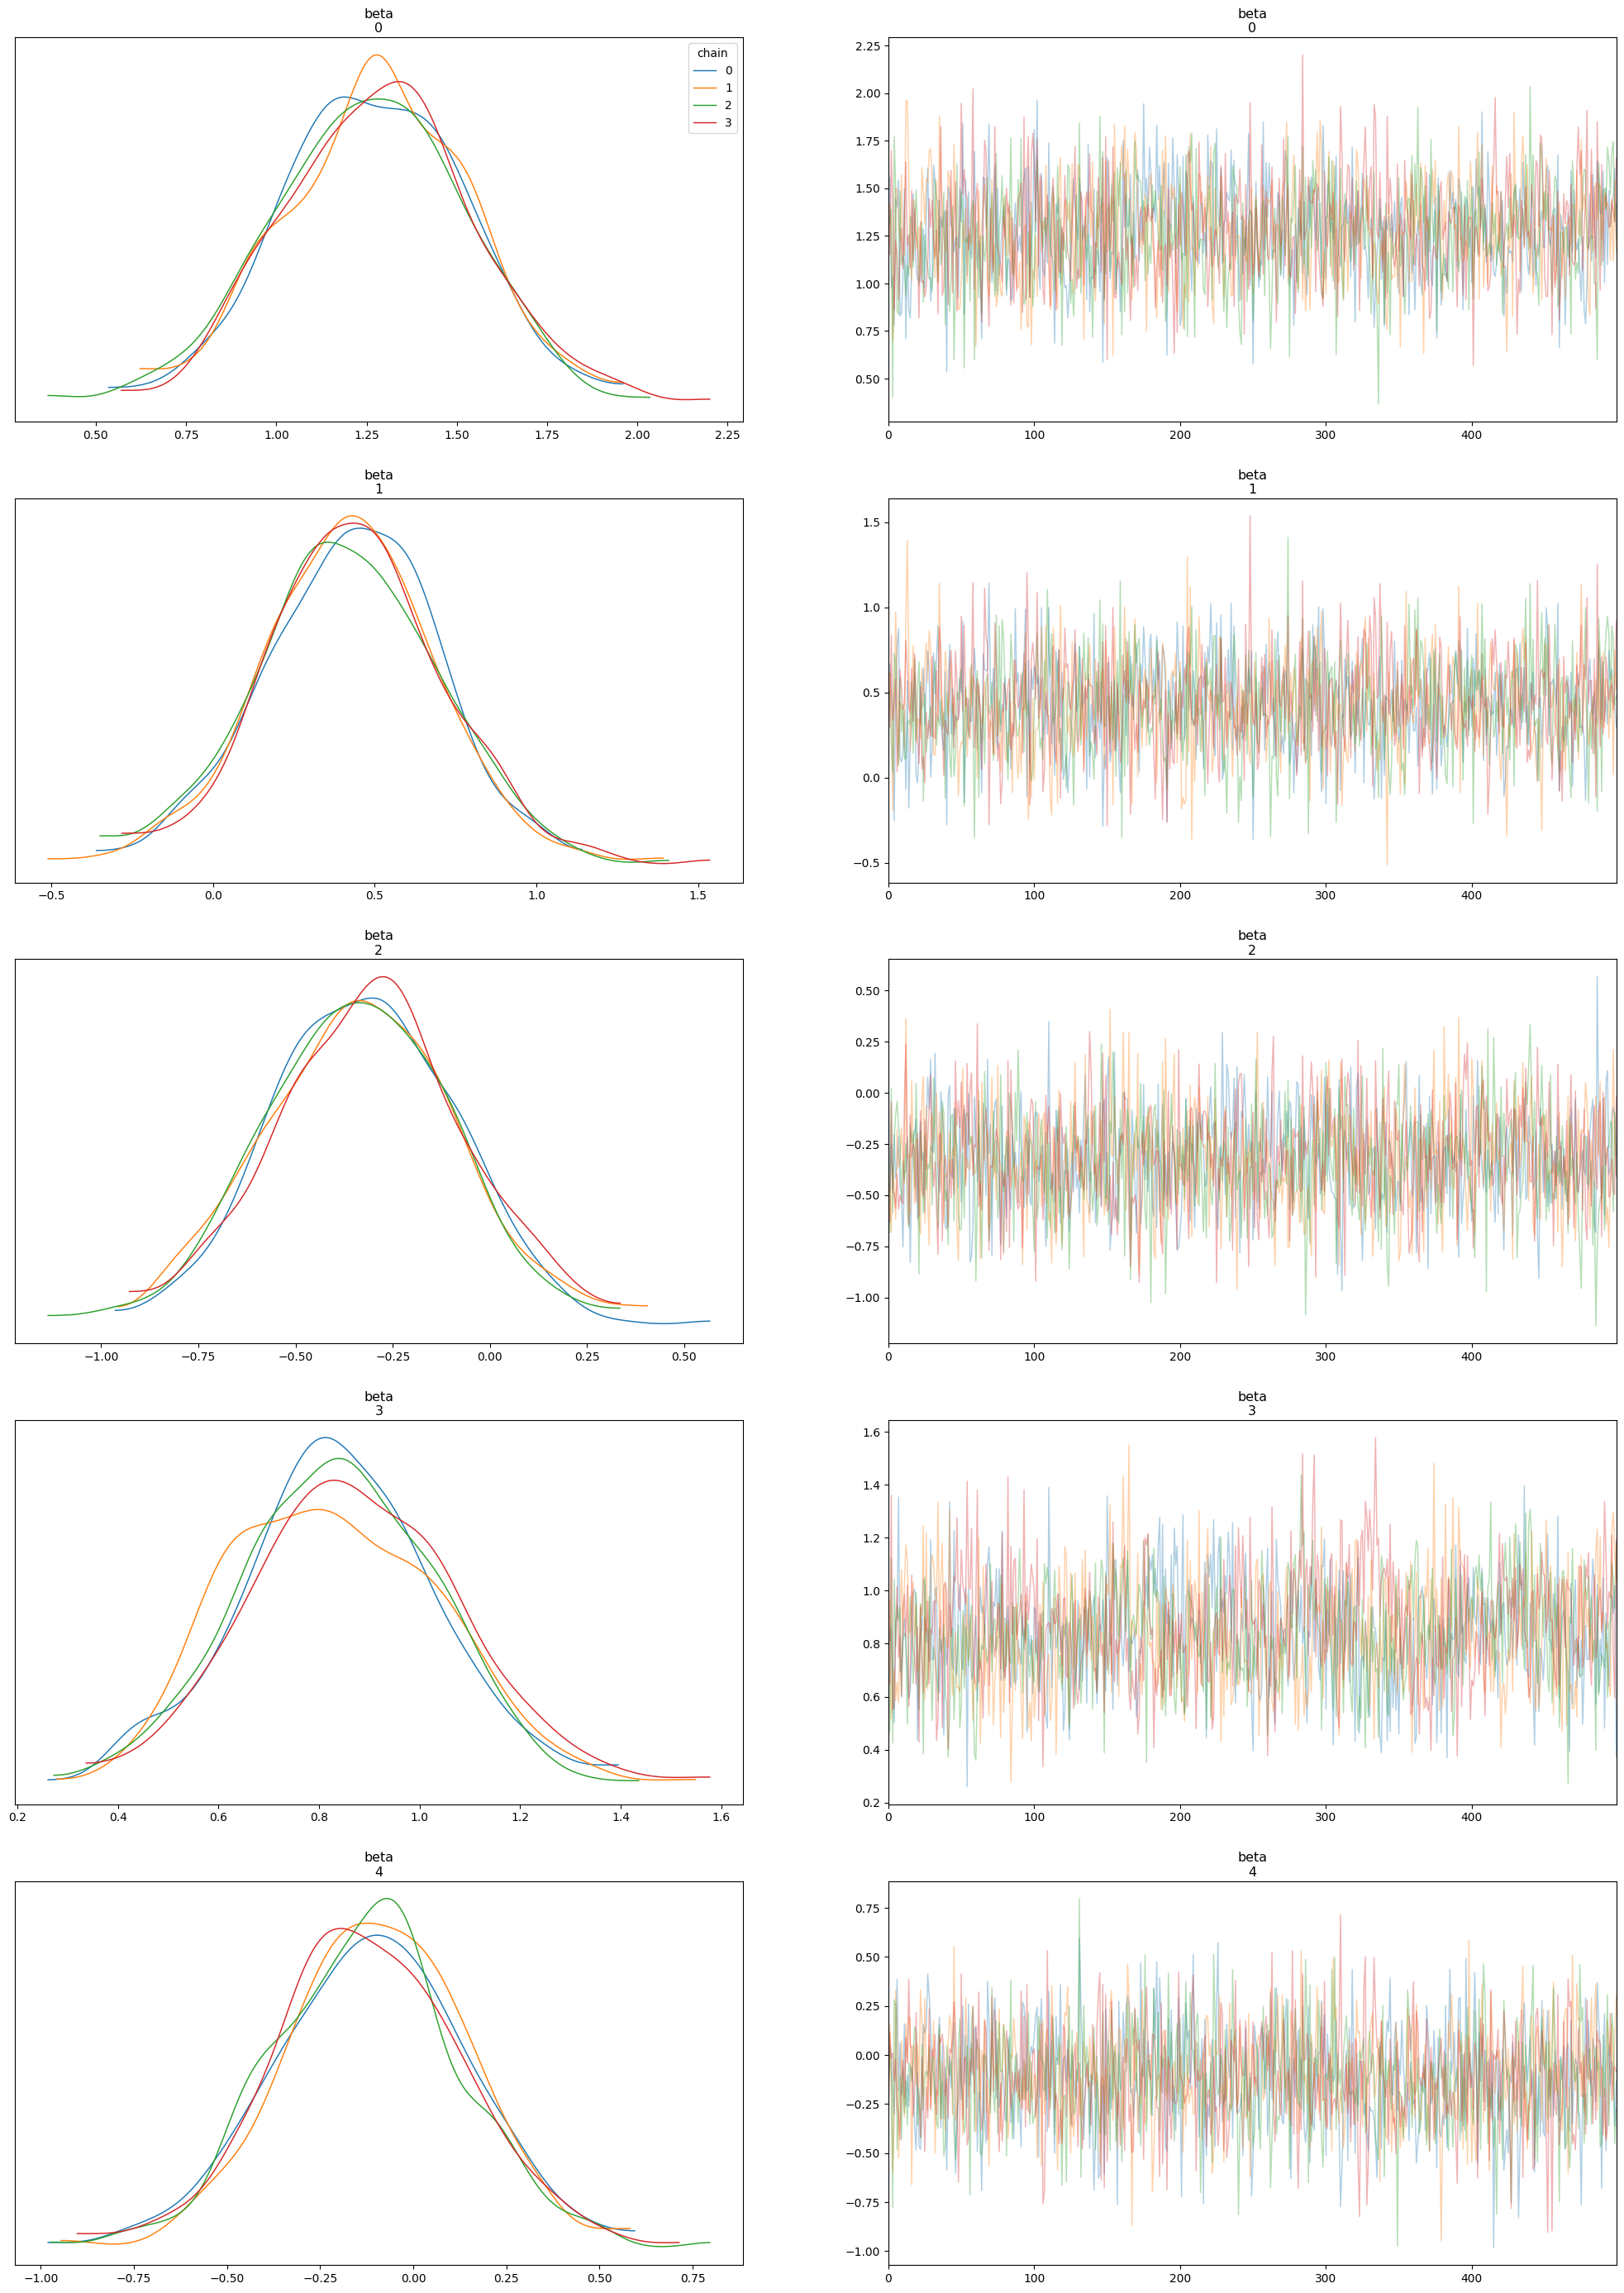

In [ ]:
az.plot_trace(az_fit, ["beta","lambda"], figsize=(20,8), legend=True)
az.plot_trace(az_fit, ["beta"], figsize=(25,35), legend=True, compact=False)

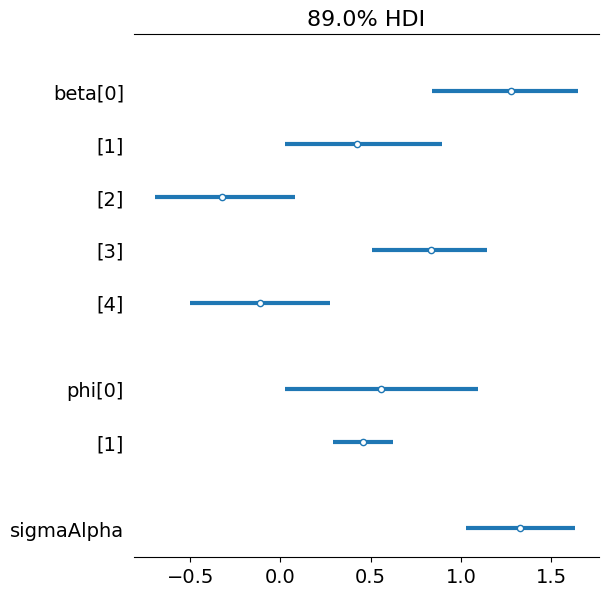

In [ ]:
axes = az.plot_forest(az_fit,
                        kind='forestplot',
                        combined=True,
                        quartiles=False,
                        hdi_prob=0.89,
                        var_names=['beta','phi','sigmaAlpha']
                        )

In [ ]:
# sort alpha parameters based on mean
alpha_mean = az_fit.posterior.alpha.to_numpy().mean(axis=(0,1))
print(alpha_mean.argsort()[:5])

[1350  280 1598 1770 1348]


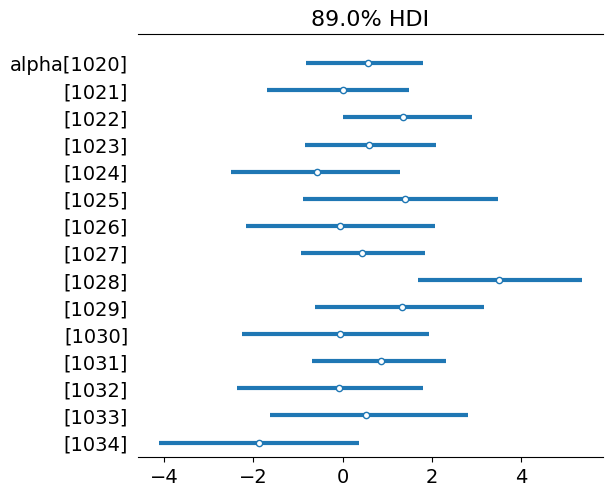

In [ ]:
plot_data = az_fit.posterior.alpha[:,:,1020:1035]
axes = az.plot_forest(plot_data,
                        kind='forestplot',
                        combined=True,
                        quartiles=False,
                        hdi_prob=0.89
                        )

In [ ]:
print(itovp['1028'])
#1 = Slovenia voting for Croatia!

print(itovp['2054'])
#2 = Germany voting for Turkey!
print(itovp['592'])
#3 = Netherlands voting for Germany!
print(itovp['1557'])
#4 = Belgium voting for Netherlands!

print(itovp['1350'])
# Most negative Montenegro voting for Latvia

print(itovp['280'])
# 2nd most neg Andorra voting for Belgium


SI-HR
DE-TR
NL-DE
BE-NL
ME-LV
AD-BE
